### **Using OpenAI Whisper**
#### Transcribing TikTok videos

##### *Author: @Jyontika Kapoor*

In [63]:
from openai import OpenAI
import requests
from docx import Document
import os
import whisper
import pandas as pd
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import json 
import matplotlib.pyplot as plt
import librosa
from langdetect import detect
cwd = os.getcwd()

### Pre-Processing CSVs

In [17]:
### Merging Audrey and Tayae's videos

poster = pd.read_csv("/Users/jyontika/Documents/GitHub/CS315-Project-2/analysis/news_accs/news_by_poster.csv")

hashtag = pd.read_csv("/Users/jyontika/Documents/GitHub/CS315-Project-2/analysis/hashtag_initial/news_by_hashtag.csv")

nyt = pd.read_csv("/Users/jyontika/Documents/GitHub/CS315-Project-2/analysis/use_by_week_highsim_55.csv")


# Merge the DataFrames and keep only the 'video_id' column
merged_df = pd.concat([poster['video_id'], hashtag['video_id'], nyt['video_id']], ignore_index=True)

# remove duplicates
merged_df = merged_df.drop_duplicates()

merged_df




0      6988185257426128133
1      7283179469001461035
2      6948100100992322821
3      7307673039922105643
4      7306609553305652510
              ...         
935    7285518066920738094
938    7283936646528093482
940    7288050618646760746
941    7288063740715470110
942    7284427941948427566
Name: video_id, Length: 834, dtype: int64

In [23]:
##Change the video_ids to URLs

urls = ["https://www.tiktokv.com/share/video/" + str(video_id) + "/" for video_id in merged_df]

# convert  list of URLs to a DataFrame
urls_df = pd.DataFrame(urls, columns=['Link'])

print(urls_df)

                                                  Link
0    https://www.tiktokv.com/share/video/6988185257...
1    https://www.tiktokv.com/share/video/7283179469...
2    https://www.tiktokv.com/share/video/6948100100...
3    https://www.tiktokv.com/share/video/7307673039...
4    https://www.tiktokv.com/share/video/7306609553...
..                                                 ...
829  https://www.tiktokv.com/share/video/7285518066...
830  https://www.tiktokv.com/share/video/7283936646...
831  https://www.tiktokv.com/share/video/7288050618...
832  https://www.tiktokv.com/share/video/7288063740...
833  https://www.tiktokv.com/share/video/7284427941...

[834 rows x 1 columns]


In [29]:
## randomly sample some of the URLs

urls_df = urls_df.sample(n=450, random_state=123)

urls_df

,Link
117,https://www.tiktokv.com/share/video/7303041350...
485,https://www.tiktokv.com/share/video/7295871746...
261,https://www.tiktokv.com/share/video/7307665132...
227,https://www.tiktokv.com/share/video/7289861490...
771,https://www.tiktokv.com/share/video/7292366417...
...,...
753,https://www.tiktokv.com/share/video/7288933581...
221,https://www.tiktokv.com/share/video/7269101318...
268,https://www.tiktokv.com/share/video/7301058221...
264,https://www.tiktokv.com/share/video/7307277057...


In [30]:
json_data = urls_df.to_dict(orient='records')

# Export the JSON data to a file
with open("sampled_tiktok_urls.json", "w") as json_file:
    json.dump(json_data, json_file, indent=4)




### After Running PykTok

In [36]:
#read in two CSVs

not_downloaded_df = pd.read_csv('failed-to-locate-3-28.csv')
downloaded_vids = pd.read_csv("results-3-28.csv")

#remove not downloaded IDs from downloaded_vids csv

#1) extract IDs from URLs
not_downloaded_ID = not_downloaded_df['video_url'].str.extract(r'(\d+)/$')[0].tolist() 

not_downloaded_ID = [int(x) for x in not_downloaded_ID] #make an integer

#Remove rows with matching video_id
downloaded_vids = downloaded_vids[~downloaded_vids['video_id'].isin(not_downloaded_ID)]

#Save videos that were actually downloaded to csv
downloaded_vids.to_csv('videos_downloaded.csv', index=False)

In [44]:
len(not_downloaded_ID) #44 failed to locate 

44

In [54]:
downloaded_vids.shape #406 downloaded 

(406, 20)

In [52]:
# See how many videos came from each data frame

poster_ID = poster["video_id"].tolist()
hashtag_ID = hashtag["video_id"].tolist()
nyt_ID = nyt["video_id"].tolist()
downloaded_ID = downloaded_vids["video_id"].tolist()


poster_downloaded = []
hashtag_downloaded = []
nyt_downloaded = []

for video_id in downloaded_ID:

    if video_id in poster_ID:
        poster_downloaded.append(video_id)

    elif video_id in hashtag_ID:
        hashtag_downloaded.append(video_id)

    elif video_id in nyt_ID:
        nyt_downloaded.append(video_id)



In [53]:
size_nyt = len(nyt_downloaded)
size_hashtag = len(hashtag_downloaded)
size_poster = len(poster_downloaded)
size_total = size_nyt + size_hashtag + size_poster 

print("There were {} videos from poster dataframe, \n {} videos from hashtag dataframe, \n and {} videos from New York Times dataframe. \n There were a total of {} videos downloaded.".format(size_poster, size_hashtag, size_nyt, size_total))

There were 45 videos from poster dataframe, 
 156 videos from hashtag dataframe, 
 and 205 videos from New York Times dataframe. 
 There were a total of 406 videos downloaded.


In [55]:
downloaded_video_ids = downloaded_vids['video_id']
downloaded_video_ids

1      7295871746870086954
2      7307665132706909483
3      7289861490230709547
4      7292366417037364510
5      7302509162590702890
              ...         
434    7302246616499506465
435    7269101318369709355
436    7301058221450595630
437    7307277057585630495
438    7292144136512146731
Name: video_id, Length: 406, dtype: int64

### Transcription

In [18]:
#client = OpenAI(api_key=XYZ)

!pip install git+https://github.com/openai/whisper.git

In [56]:

# Load the WhisperProcessor and WhisperForConditionalGeneration models
processor = WhisperProcessor.from_pretrained("openai/whisper-large")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")

# set forced_decoder_ids to None for unforced context tokens
model.config.forced_decoder_ids = None  



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [57]:
output_path = "txt-transcripts/"

# define sampling rate
sampling_rate = 16000  

for video_id in downloaded_video_ids:
    audio_path = f"videos/share_video_{video_id}_.mp4"


    if os.path.exists(audio_path):

        # load the audio file using librosa
        audio, sr = librosa.load(audio_path, sr=sampling_rate)

        # process the audio using WhisperProcessor
        input_features = processor(audio, sampling_rate=sampling_rate, return_tensors="pt").input_features

        # generate token ids for transcription
        predicted_ids = model.generate(input_features)

        # decode token ids to text
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

        # write transcription to a text file named after the video ID
        with open(os.path.join(output_path, f"{video_id}.txt"), "w", encoding="utf-8") as txt:
            txt.write(transcription)

    else:
        # If audio file not found (this makes sense actually because all of these videos were not downloaded)
        print(f"Audio for video ID {video_id} not found.")


/var/folders/94/hzlwrw5d571cgm5snsf618b00000gn/T/ipykernel_60173/3110332860.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=sampling_rate)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
/var/folders/94/hzlwrw5d571cgm5snsf618b00000gn/T/ipykernel_60173/3110332860.py:13: UserWarning: PySoundFile failed. Trying audiore

### After Transcriptions

In [58]:
folder_path = os.path.join(cwd, 'txt-transcripts')
data = []

#iterate through all TXT files 
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            file_name = os.path.splitext(filename)[0]  # get video id
            file_content = file.read() #get the content
            file_length = len(file_content) #get length
            if file_name in poster_downloaded:
                original_comparison = 'poster'
            elif file_name in hashtag_downloaded:
                original_comparison = 'hashtag'
            elif file_name in nyt_downloaded:
                original_comparison = 'nyt'
            else:
                original_comparison = None
            data.append([file_name, file_content, file_length, original_comparison])

# Create a DF
transcription_df = pd.DataFrame(data, columns=['Video_ID', 'Transcription', 'Length', 'Original Comparison'])
print(transcription_df)



                Video_ID                                      Transcription  \
0    7300021255258901806                                         I'm sorry.   
1    7236076693822246170                                              Outro   
2    7301769517041126702            Okay, right. No, I'm getting with this.   
3    7289191984529575214   People, open your eyes. We are supporting gen...   
4    7297432141485444394   The Zionist argument we will address today is...   
..                   ...                                                ...   
401  6866180645400431877   Do you have supervision? I'm going to give yo...   
402  7298890303744806174   Guess this song. I... hint Taylor Swift. Oh.....   
403  7300191041280412933                      Nothing's new, nothing's new.   
404  7295818404936584491   The amount of people okay that feel like this...   
405  7302568573396913451   And as my mind begins to spread its wings The...   

     Length Original Comparison  
0        11      

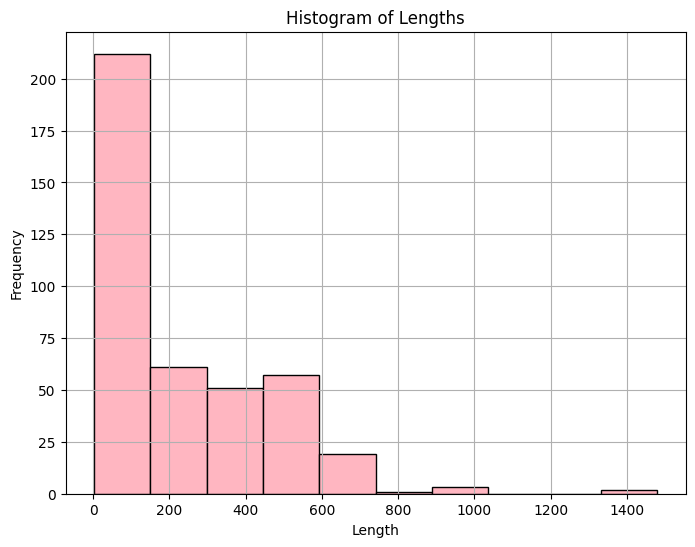

In [59]:
# Plot a histogram of file lengths
plt.figure(figsize=(8, 6))
plt.hist(transcription_df['Length'], color='lightpink', edgecolor='black')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [65]:
###Eliminate any non-English transcriptions

def detect_language(text):
    """function to detect language"""
    try:
        lang = detect(text)
        return lang == 'en'  # Return True if language is English
    except:
        return False  # Return False if an error occurs during language detection

# filter rows with English text
transcription_df = transcription_df[transcription_df['Transcription'].apply(detect_language)]

print(transcription_df.shape)

(320, 4)


In [ ]:
### Compare lengths of transcription with keywords 